## Leitura de imagens não usadas no treinamento para teste de resultado

#### Validação Multiclasse


In [1]:
import torch
from transformers import ViTForImageClassification
import pytorch_lightning as pl
import torch.nn as nn

import sys
import os

dir_raiz = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(dir_raiz)
from classes.modelo import Modelo
from classes.modelo_custom import ModeloCustom
from classes.modelo_binario import ModeloBin


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_classes = 1
learning_rate = 0.001

### Load Modelo Completo

In [6]:
# Instancie o modelo
# model = ModeloCustom(num_classes, learning_rate)
# model = Modelo(num_classes, learning_rate)
model = ModeloBin(num_class=num_classes, learning_rate=learning_rate)

# Carregue o estado do modelo salvo
model.load_state_dict(torch.load('models/modelo_vit_gpu.pth', map_location="cpu"))
model.eval() 

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=1

ModeloBin(
  (model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=192, out_features=192, bias=True)
                (key): Linear(in_features=192, out_features=192, bias=True)
                (value): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (inter

### Load Checkpoint

In [ ]:
model = ModeloBin(num_class=num_classes, learning_rate=learning_rate)
model = Modelo.load_from_checkpoint("models/checkpoint/epoch=29-val_loss=0.31-val_accuracy=0.86.ckpt")
print(model.learning_rate)

### Avaliar pelo conjunto de Validação


In [10]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import os

def get_key_from_value(dicte, target_value):
    for key, value in dicte.items():
        if value == target_value:
            return key
    return None

def avaliarModelo(path_paste):
  all_files_and_dirs = os.listdir(path_paste)

  # Filtra apenas os arquivos
  files = [f for f in all_files_and_dirs if os.path.isfile(os.path.join(path_paste, f))]

  for i, file in enumerate(files):
    
    
    image_path = f"{path_paste}/{file}"
    image = Image.open(image_path).convert('RGB')

    # Transforme a imagem
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image_tensor = transform(image).unsqueeze(0)  # Adicione uma dimensão para o batch

    # Certifique-se de que o modelo está em modo de avaliação
    model.eval()

    # with torch.no_grad():
    #   # Faça a previsão
    #   output = model(image_tensor)
    #   probabilities = torch.softmax(output, dim=1)
    #   prediction = torch.argmax(probabilities, dim=1).item()

    with torch.no_grad():
      output = model(image_tensor)

      probabilities = torch.sigmoid(output)

      prediction = (probabilities > 0.5).int().item() 
    
    # Exibir a imagem
    plt.imshow(image)
    plt.axis('off')  # Não exibir os eixos
    
    
    # dicte = {'ASC-H': 0, 'ASC-US': 1, 'HSIL': 2, 'LSIL': 3, 'Negative for intraepithelial lesion': 4, 'SCC': 5}
    # dicte = {'ASC-H': 0, 'ASC-US': 1, 'HSIL': 2, 'LSIL': 3, 'SCC': 4}
    dicte = {'Negative for intraepithelial lesion': 0, 'Positive for intraepithelial lesion': 1}
    
    retorno = get_key_from_value(dicte=dicte, target_value=prediction)
    
    plt.title(f'Predicted class: {retorno}')
    plt.show()
    
    if i == 15:
      break


In [ ]:
avaliarModelo("data/base_treinamento/validate/ASC-H")

In [ ]:
avaliarModelo("data/base_treinamento/validation/ASC-US")

In [ ]:
avaliarModelo("data/base_treinamento/validation/HSIL")

In [ ]:
avaliarModelo("data/base_treinamento/validation/LSIL")

In [ ]:
avaliarModelo("data/base_treinamento/validation/Negative for intraepithelial lesion")

In [ ]:
avaliarModelo("data/base_treinamento/validation/SCC")

### Avaliar pelo conjunto de Teste


In [9]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import os

def get_key_from_value(dicte, target_value):
    for key, value in dicte.items():
        if value == target_value:
            return key
    return None

def avaliarModeloNumero(path_paste, resposta):
  all_files_and_dirs = os.listdir(path_paste)

  # Filtra apenas os arquivos
  files = [f for f in all_files_and_dirs if os.path.isfile(os.path.join(path_paste, f))]

  qtd_total = len(files)
  
  contador_certo = 0
  
  for i, file in enumerate(files):
        
    image_path = f"{path_paste}/{file}"
    image = Image.open(image_path).convert('RGB')

    # Transforme a imagem
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image_tensor = transform(image).unsqueeze(0)  # Adicione uma dimensão para o batch

    # Certifique-se de que o modelo está em modo de avaliação
    model.eval()

    # with torch.no_grad():
    #   # Faça a previsão
    #   output = model(image_tensor)
    #   probabilities = torch.softmax(output, dim=1)
    #   prediction = torch.argmax(probabilities, dim=1).item()

    with torch.no_grad():
      output = model(image_tensor)

      probabilities = torch.sigmoid(output)

      prediction = (probabilities > 0.5).int().item() 
    
    # dicte = {'ASC -H': 0, 'ASC-US': 1, 'HSIL': 2, 'LSIL': 3, 'Negative for intraepithelial lesion': 4, 'SCC': 5}
    # dicte = {'ASC-H': 0, 'ASC-US': 1, 'HSIL': 2, 'LSIL': 3, 'SCC': 4}
    dicte = {'Negative for intraepithelial lesion': 0, 'Positive for intraepithelial lesion': 1}
    
    retorno = get_key_from_value(dicte=dicte, target_value=prediction)
    
    if retorno == resposta:
      contador_certo += 1
      
  return f'{contador_certo}/{qtd_total}'
    
  

### Binario

In [59]:
negativa = []
positiva = []

In [60]:
value = avaliarModeloNumero("data/base_treinamento/test/Negative for intraepithelial lesion", "Negative for intraepithelial lesion")
value_s = value.split("/")
negativa.append( int(value_s[0]))
value

'1184/1356'

In [61]:
value = avaliarModeloNumero("data/base_treinamento/test/Negative for intraepithelial lesion", "Positive for intraepithelial lesion")
value_s = value.split("/")
negativa.append(int(value_s[0]))
value

'172/1356'

In [62]:
value = avaliarModeloNumero("data/base_treinamento/test/Positive for intraepithelial lesion", "Negative for intraepithelial lesion")
value_s = value.split("/")
positiva.append(int(value_s[0]))
value

'142/951'

In [63]:
value = avaliarModeloNumero("data/base_treinamento/test/Positive for intraepithelial lesion", "Positive for intraepithelial lesion")
value_s = value.split("/")
positiva.append(int(value_s[0]))
value

'809/951'

In [67]:
positiva, negativa

([142, 809], [1184, 172])

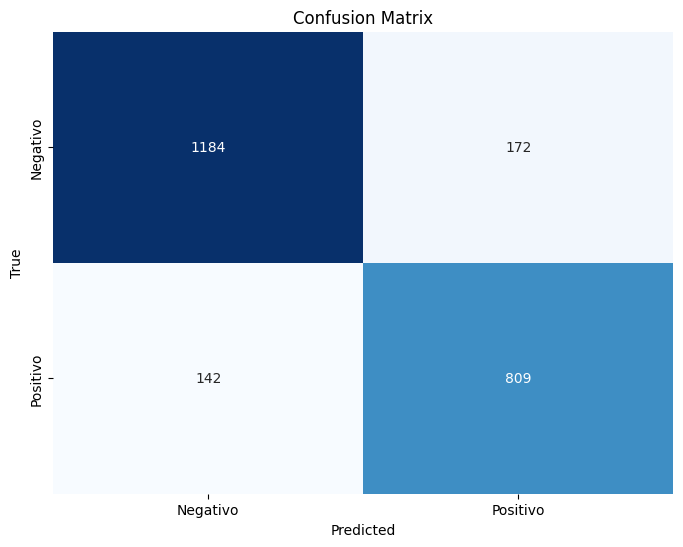

In [68]:

conf_matrix = np.array([
  negativa,
  positiva
])

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Multiclass

In [19]:
avaliarModeloNumero("data/base_treinamento/test/ASC-H", "ASC-H")

'68/68'

In [20]:
avaliarModeloNumero("data/base_treinamento/test/ASC-US", "ASC-US")

'84/86'

In [21]:
avaliarModeloNumero("data/base_treinamento/test/HSIL", "HSIL")

'236/237'

In [22]:
avaliarModeloNumero("data/base_treinamento/test/LSIL", "LSIL")

'135/137'

In [ ]:
avaliarModeloNumero("data/base_treinamento/test/Negative for intraepithelial lesion", "Negative for intraepithelial lesion")

In [23]:
avaliarModeloNumero("data/base_treinamento/test/SCC", "SCC")

'27/28'

#### Confusion Matrix

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

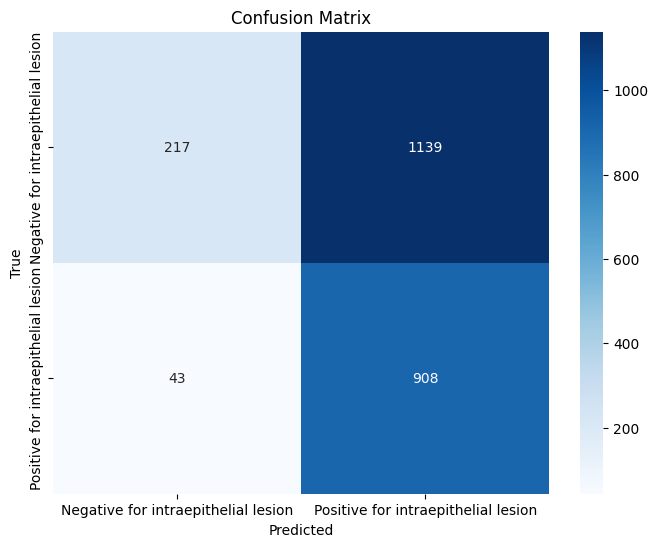

In [37]:


def calcular_matriz_confusao():

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    test_dataset = ImageFolder(root="data/base_treinamento/test/", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            probabilities = torch.sigmoid(output)
            predicted = (probabilities > 0.5).int()
            

            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    
    print(all_preds)            
    print(all_labels)            
    print(len(all_preds))            
    print(len(all_labels))            
    # Gerar a matriz de confusão
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    # plt.savefig(output_path)
    plt.show()
    
    # return conf_matrix
  
calcular_matriz_confusao()